In [94]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import cv2

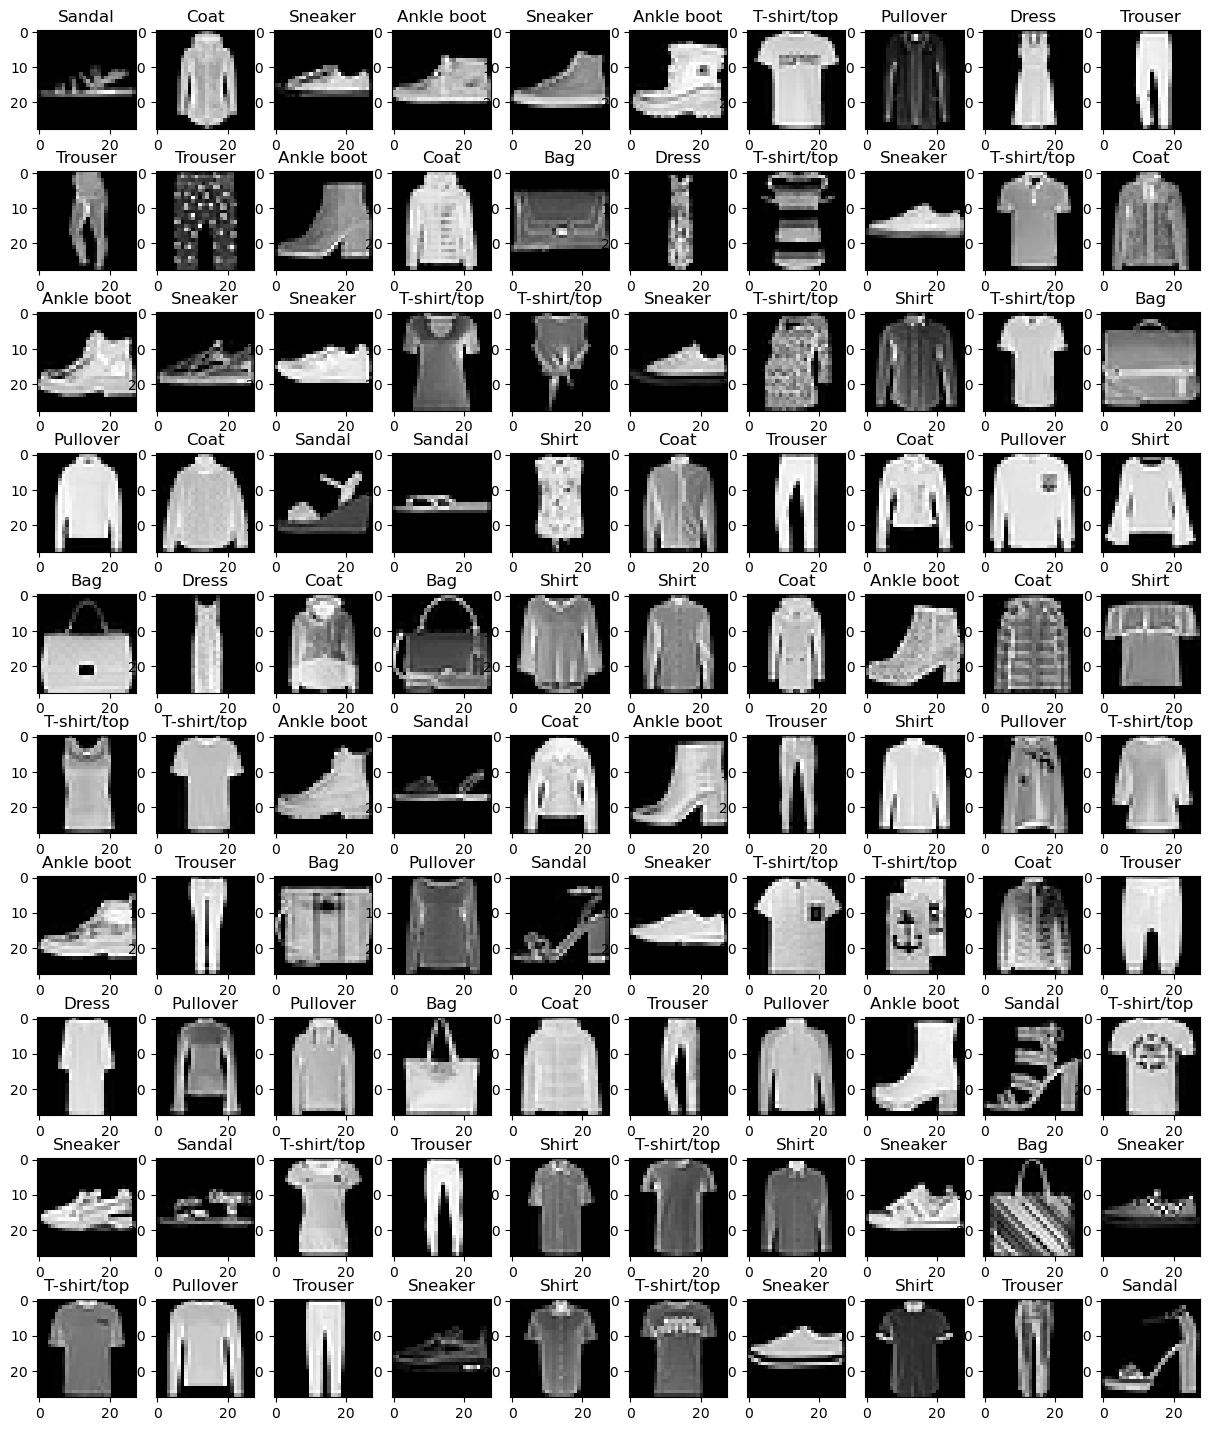

In [95]:
# 数据预处理
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
# 加载数据训练集
trainset=torchvision.datasets.FashionMNIST(root='./data',train=True,download=False,transform=transform)
trainload=torch.utils.data.DataLoader(trainset,shuffle=True,batch_size=100,num_workers=0)
# 加载测试数据集
testset=torchvision.datasets.FashionMNIST(root='./data',train=False,download=False,transform=transform)
testload=torch.utils.data.DataLoader(testset,shuffle=True,batch_size=100,num_workers=0)

classes=('T-shirt/top', 'Trouser', 'Pullover', 'Dress','Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

# 数据获取迭代器
dataiter=iter(trainload)
imgs,labels=next(dataiter)
# 显示部分图像
row=10
column=10
pos=1
plt.figure(figsize=(15,18))
for i in range(row):
    for j in range(column):
        plt.subplot(row,column,pos)
        plt.imshow(imgs[pos-1].numpy().squeeze(),cmap='gray')
        plt.title(classes[labels[pos-1].item()])
        pos+=1


In [151]:

#使用pytorch构建一个多层感知机（MLP）模型
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# 设置MLP模型的参数
input_size = 784  # Input size for MNIST dataset (28x28 pixels)
hidden_size = 256  #隐层单元数量
num_classes = 10  # Number of classes (0-9 digits)

# 构建模型
model = MLP(input_size, hidden_size, num_classes)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [152]:
# 训练模型
device=torch.device("cpu")
model=model.to(device)
max_epoch = 10
for epoch in range(max_epoch):
    running_loss=0
    
    print(f'Iteration {epoch+1}/{max_epoch}')
    for i, data in enumerate(trainload,start=0):
            images, labels = data  # 获取训练集的批图像和标签
            
            # images变为列向量
            inputs = images.view(images.size(0), -1)

            inputs,labels=inputs.to(device),labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # 后向传播
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            # 打印loss
            if i % 100 == 99:
                print('[%d, %3d/%3d] loss: %.3f' %(epoch + 1, i + 1,len(trainload), running_loss / 100))
                running_loss = 0.0

Iteration 1/10
[1, 100/600] loss: 0.719
[1, 200/600] loss: 0.509
[1, 300/600] loss: 0.475
[1, 400/600] loss: 0.448
[1, 500/600] loss: 0.429
[1, 600/600] loss: 0.423
Iteration 2/10
[2, 100/600] loss: 0.400
[2, 200/600] loss: 0.369
[2, 300/600] loss: 0.366
[2, 400/600] loss: 0.376
[2, 500/600] loss: 0.368
[2, 600/600] loss: 0.369
Iteration 3/10
[3, 100/600] loss: 0.344
[3, 200/600] loss: 0.345
[3, 300/600] loss: 0.332
[3, 400/600] loss: 0.334
[3, 500/600] loss: 0.329
[3, 600/600] loss: 0.327
Iteration 4/10
[4, 100/600] loss: 0.312
[4, 200/600] loss: 0.303
[4, 300/600] loss: 0.317
[4, 400/600] loss: 0.312
[4, 500/600] loss: 0.307
[4, 600/600] loss: 0.317
Iteration 5/10
[5, 100/600] loss: 0.294
[5, 200/600] loss: 0.286
[5, 300/600] loss: 0.297
[5, 400/600] loss: 0.290
[5, 500/600] loss: 0.303
[5, 600/600] loss: 0.283
Iteration 6/10
[6, 100/600] loss: 0.283
[6, 200/600] loss: 0.265
[6, 300/600] loss: 0.279
[6, 400/600] loss: 0.275
[6, 500/600] loss: 0.280
[6, 600/600] loss: 0.275
Iteration 

In [153]:
# 测试模型

model.eval()
correct = 0
total = 0
TN,TP,FN,FP=np.zeros(10),np.zeros(10),np.zeros(10),np.zeros(10)
# 不进行梯度计算，加快预测速度
with torch.no_grad():
    for data in testload:
        images, labels = data
        inputs = images.view(images.size(0), -1)
        inputs,labels=inputs.to(device),labels.to(device)
        outputs = model(inputs)
        #获取预测的类别
        _, predicted = torch.max(outputs.data, 1)
        
        '''
        Weight-average:对每类的评价指标进行加权求和,求得整个的评价指标
        计算每个类别的准确率、召回率、F1值
        然后对每个类别的评价指标进行加权求和，求得整个的评价指标
        TP:预测为正例的样本中，实际为正例的样本数
        FN:预测为负例的样本中,实际为正例的样本数
        FP:预测为正例的样本中,实际为负例的样本数
        TN:预测为负例的样本中,实际为负例的样本数
        '''
        TN += labels.shape[0];
        for i in range(predicted.shape[0]):
            #预测成功(预测为正例且实际为正例，或者预测为负例且实际为负例)
            if predicted[i] == labels[i]:
                #对于标签为predicted[i]的类别(TP)和其他类别(TN)来说都预测成功
                TP[predicted[i]]+=1
                TN[predicted[i]]-=1
            #预测失败（预测为正例但实际为负例，或者预测为负例而实际为正例）
            else:
                #对标签为predicted[i]的类别(FP),对于标签为labels[i]的类别(FN)
                FP[labels[i]]+=1
                FN[predicted[i]]+=1
                TN[labels[i]]-=1
                TN[predicted[i]]-=1
        
# 计算准确率，召回率，F1值
total=TP+FP+FN+TN
print('total:',total)  
accuracy = (TP + TN) / total
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall) 
weight=total/total.sum()
print(weight)
total_accuracy=np.sum(accuracy*weight)
total_precision=np.sum(precision*weight)
total_recall=np.sum(recall*weight)
total_f1=np.sum(f1*weight)
print('Accuracy: %.3f' % total_accuracy)
print('Precision: %.3f' % total_precision)
print('Recall: %.3f' % total_recall)
print('F1 score: %.3f' % total_f1)


total: [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.]
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Accuracy: 0.976
Precision: 0.882
Recall: 0.884
F1 score: 0.882


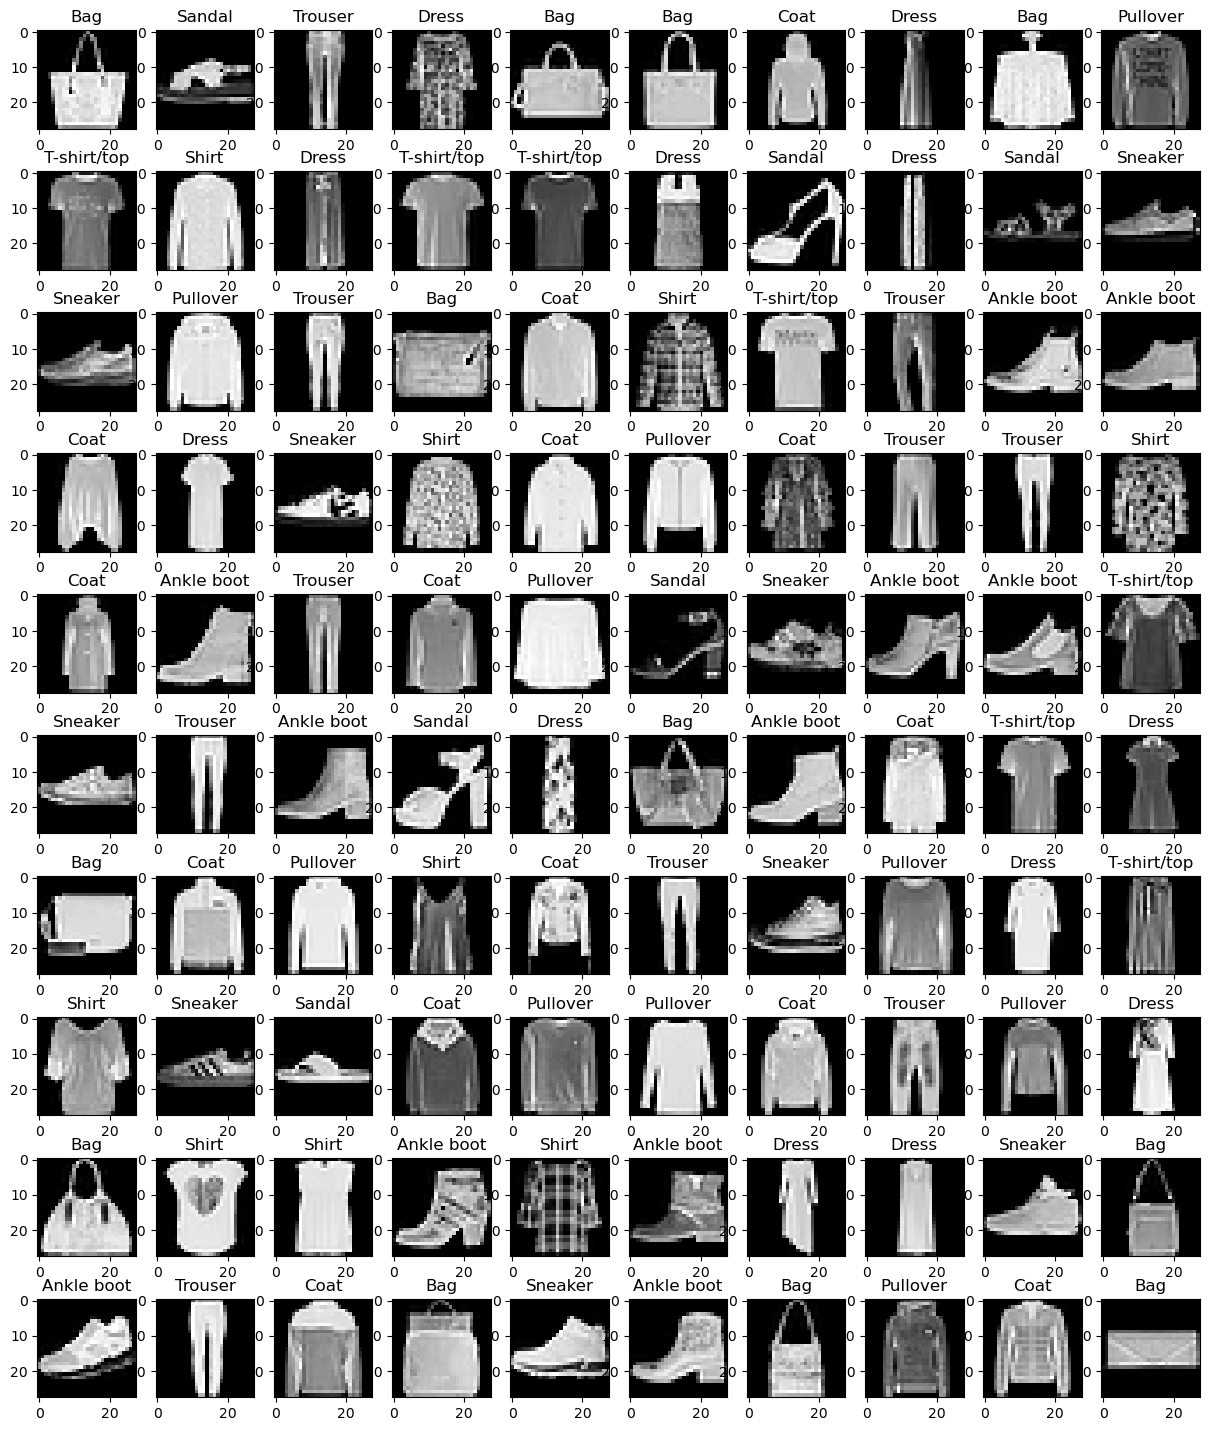

In [127]:
#把predict_list转换为numpy
preds = predicted.numpy()

#打印部分预测结果
plt.figure(figsize=(15,18))
pos = 1
for i in range(row):
    for j in range(column):
        plt.subplot(row,column,pos)
        plt.imshow(images[pos-1].numpy().squeeze(),cmap='gray')
        plt.title(classes[preds[pos-1]])
        pos+=1

(28, 28)
Trouser


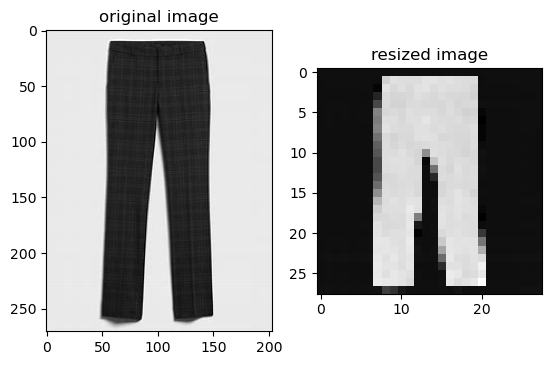

In [159]:
#预测图片
im = cv2.imread('./source/trouser.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
resized_image = cv2.resize(im, (28, 28))
print(resized_image.shape)
#将图片反相
resized_image = 255 - resized_image
#预处理图片
input = transform(resized_image)  
# 把resize后的图片转化为列向量
input = input.view(1, -1)
# 把im转化为tensor
input = input.clone().detach().requires_grad_(True)
plt.subplot(1,2,1)
plt.imshow(im, cmap='gray')
plt.title('original image')
plt.subplot(1,2,2)
plt.imshow(resized_image, cmap='gray')
plt.title('resized image')

with torch.no_grad():
    outputs = model(input)
    _, predict = torch.max(outputs.data, 1) # 索引即classed中的类别
print(classes[predict])